### Setup environment

We can control a multitude of parameters from the starts :
Notably the input shape, the number of classes (101 for the Food101 dataset), the extractor name (only a list of extractors is available).

Moreover, only the dense classifier type is supported and it's free for us to specifiy the number of layers (with each's dimension). Do note that at the end is added the final layer (101 components with activation softmax).

In [14]:
INPUT_SHAPE = (224, 224, 3)
NUM_CLASSES = 101
EXTRACTOR_NAME =  "EfficientNetV2B1"
CLASSIFIER_TYPE = "dense"
CLASSIFIER_PARAMETERS = [256,]
DATA_AUGMENT = True
CUTMIX_AUGMENT = False


In order to lead the dataset we use tensorflow datasets

In [ ]:
!pip install tensorflow_datasets # TensorFlow Datasets Module to load dataset

In [ ]:
import matplotlib.pyplot as plt
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf
from utilities.helper import create_tensorboard_callback

# Create ModelCheckpoint callback to save model's progress
checkpoint_path = "model_checkpoints/cp.ckpt" # 
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      montior="val_accuracy", # Track the validation accuracy for best model to save
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=True, # 
                                                      verbose=1) 

from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16") # set global policy to mixed precision (for GPU)

*NB* : Here we activate mixed precision training.

### Data acquisition and handling
First we define our data augmentation techniques. We then download/load the dataset and add the proper transformations necessary.

In [16]:
from tensorflow.keras import layers

def generate_data_augmentation_fn():
  rf = layers.RandomFlip("horizontal_and_vertical")
  rr = layers.RandomRotation(0.2)
  rc = layers.RandomContrast(0.05)
  
  def data_augmentation(image, label):
    image = rf(image, training = True)
    image = rr(image, training = True)
    image = rc(image, training = True)
    image = tf.image.random_brightness(image, 0.1)
    return image, label 
  return data_augmentation

data_augmentation = generate_data_augmentation_fn()

In [17]:
AUTO = tf.data.AUTOTUNE

from utilities.prepare_data import prepare_data 
data_dir = "./data"
(train_data, test_data), classes = prepare_data(data_dir)

from utilities import preprocess
train_data = train_data.map(map_func=preprocess.preprocess_img, num_parallel_calls=AUTO)


if DATA_AUGMENT:
    train_data = train_data.map(map_func= data_augmentation ,
                                num_parallel_calls=AUTO)
if CUTMIX_AUGMENT:
    train_full = tf.data.Dataset.zip((train_data, train_data.shuffle(buffer_size= 1000)))

    train_data = train_full.map(map_func=preprocess.cutmix,
                                num_parallel_calls=AUTO)
 
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=AUTO)

test_data = test_data.map(preprocess.preprocess_img, num_parallel_calls=AUTO)
test_data = test_data.batch(32).prefetch(AUTO)

Let's display the obained images.

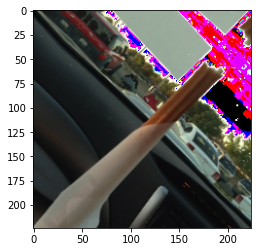

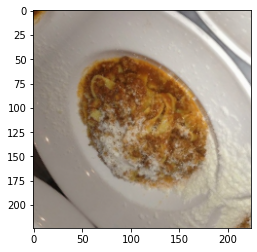

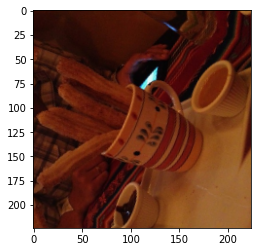

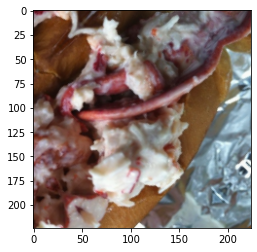

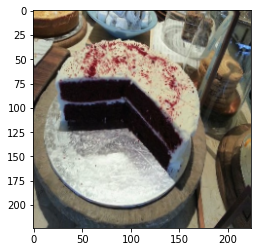

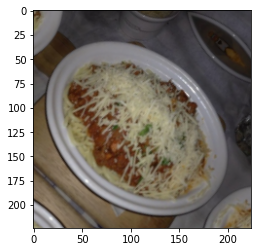

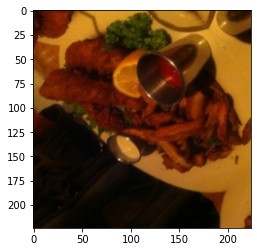

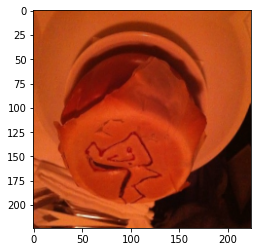

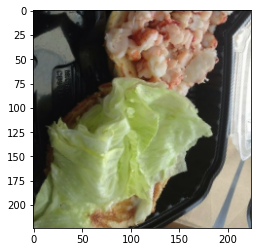

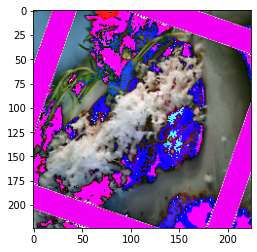

In [18]:
import matplotlib.pyplot as plt
import numpy as np 
for img, label  in train_data.take(5):
    plt.imshow(img[0].numpy().astype(np.uint8))
    plt.show()

### Model Building + Training

#### Creation
For this we will use the wrapper class we have defined, the parameters are as indicated in the arguments.

In [7]:
from utilities import models
wrapper_model = models.full_model(INPUT_SHAPE,
                                  NUM_CLASSES,
                                  EXTRACTOR_NAME,
                                  CLASSIFIER_TYPE,
                                  CLASSIFIER_PARAMETERS)


#### Head Classifier training
For this step, we only perform transfer learning as we train the head uniquely.
The compile method for the wrapper_model supports an additional argument: unfreeze_extractor (by default False).
It is necessary to use the compile method to either freeze or unfreeze the model.

In [19]:
MODEL_LR = 10e-3 
ES_PATIENCE = 2 # early stopping patience

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=ES_PATIENCE) # if val loss decreases for 3 epochs in a row, stop training

wrapper_model.compile(optimizer= "adam",
                      loss = "sparse_categorical_crossentropy",
                      metrics = ["accuracy",  tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3)])

In [ ]:

# Fit Head classifier uniquely
hist_head_only_train = wrapper_model.model.fit(train_data, 
                                                epochs=5,
                                                steps_per_epoch=len(train_data),
                                                validation_data=test_data,
                                                validation_steps=int(0.15 * len(test_data)),
                                                callbacks=[create_tensorboard_callback("training_logs", 
                                                                                        "feature_extractor_only"),
                                                           model_checkpoint,
                                                           early_stopping])
head_only_eval = wrapper_model.model.evaluate(test_data)
print("Head classifier evaluation: ", head_only_eval)


### Finetuning entire architecture
Finally , we fine tune the entire model by unfreezing its base extractor and reducing the learning rate. In this strategy we use an early stopping with Learning rate reduction on plateau strategy.

In [10]:
ES_PATIENCE = 5 # early stopping patience
REDUCE_LR_FACTOR = 0.3 # reduce learning rate by 70% 
REDUCE_LR_PATIENCE = 3 # reduce learning rate patience for reduction
REDUCE_LR_MINLR = 1e-6 # minimum learning rate

MODEL_LR = 10e-4 # model learning rate

TRAIN_VALID_PERCENT = 0.15 # Percentage of testing data to use for validation
EPOCHS = 100

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  patience=ES_PATIENCE) 

# Learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=REDUCE_LR_FACTOR, 
                                                 patience=REDUCE_LR_PATIENCE,
                                                 verbose=1, 
                                                 min_lr=REDUCE_LR_MINLR)

# Model save callback
checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

In [ ]:
# Compile the model and unfreeze all the layers.
wrapper_model.compile(unfreeze_extractor=True,
                      optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
                      loss = "sparse_categorical_crossentropy",
                      metrics = ["accuracy", tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3)],)

# Fit the model with callbacks
hist_full_train = wrapper_model.model.fit(train_data,
                                        epochs=EPOCHS,
                                        steps_per_epoch=len(train_data),
                                        validation_data=test_data,
                                        validation_steps=int(TRAIN_VALID_PERCENT * len(test_data)),
                                        callbacks=[
                                            create_tensorboard_callback("training_logs", "data_fine_tuning"),
                                            model_checkpoint,
                                            early_stopping, 
                                            reduce_lr]) 
hist_full_eval = wrapper_model.model.evaluate(test_data)


The histories down below can be used to asses the performances of the model. It's possible to also evaluate the model (as we have done) separetely in order to extract the specific errors.

In [ ]:
print(hist_full_eval)

In [ ]:
print(hist_full_train)

In [ ]:
print(head_only_eval)

In [ ]:
print(head_only_eval)